In [10]:
import pandas as pd
import warnings 
warnings.filterwarnings('ignore')# to avoid warnings
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
Microsoft_Data=pd.read_csv('Microsoft_Data.csv')
y=Microsoft_Data['HasDetections']
Microsoft_Data.drop(columns='HasDetections',inplace=True)
#code to get missing values
missing_value_percentage_df=pd.DataFrame({'Column_Name':Microsoft_Data.columns,
                                         'Missing_Values_Count':Microsoft_Data.isnull().sum(),
                                         'Missing_Values_Percentage':Microsoft_Data.isnull().sum()/Microsoft_Data.shape[0]*100
                                         })



missing_value_percentage_df=missing_value_percentage_df.sort_values(by='Missing_Values_Percentage',ascending=False)
missing_value_percentage_df




,Column_Name,Missing_Values_Count,Missing_Values_Percentage
PuaMode,PuaMode,56737,99.966523
Census_ProcessorClass,Census_ProcessorClass,56514,99.573613
DefaultBrowsersIdentifier,DefaultBrowsersIdentifier,53983,95.114173
Census_IsFlightingInternal,Census_IsFlightingInternal,47190,83.145394
Census_InternalBatteryType,Census_InternalBatteryType,40429,71.232997
...,...,...,...
Census_PowerPlatformRoleName,Census_PowerPlatformRoleName,0,0.000000
Census_OSVersion,Census_OSVersion,0,0.000000
Census_OSArchitecture,Census_OSArchitecture,0,0.000000
Census_OSBranch,Census_OSBranch,0,0.000000


In [11]:
cols_to_drop=[]

cols_with_missing_values_grt_50=list(missing_value_percentage_df[missing_value_percentage_df['Missing_Values_Percentage']>50].index)

for col in Microsoft_Data.columns:
    if Microsoft_Data[col].nunique()==Microsoft_Data.shape[0] or Microsoft_Data[col].nunique()==1:
        cols_to_drop.append(col)
        
columns_to_drop=cols_to_drop+cols_with_missing_values_grt_50

Microsoft_Data.drop(columns=columns_to_drop,inplace=True)

Microsoft_Data.shape

(56756, 71)

In [12]:
for col in Microsoft_Data.columns:
    if col!='Census_SystemVolumeTotalCapacity':
        Microsoft_Data[col]=Microsoft_Data[col].astype(object)
        
Microsoft_Data['Census_SystemVolumeTotalCapacity'].dtype

dtype('float64')

In [13]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(Microsoft_Data,y,test_size=0.3,random_state=43)

#Filling missing values

for col in x_train.columns:
    if x_train[col].dtype=='object':
        x_train[col]=x_train[col].fillna(x_train[col].mode()[0]).astype(object)
        x_test[col]=x_test[col].fillna(x_train[col].mode()[0]).astype(object)
        
    else:
        x_train[col]=x_train[col].fillna(x_train[col].mean())
        x_test[col]=x_test[col].fillna(x_train[col].mean())
x_train.dtypes

ProductName                                object
EngineVersion                              object
AppVersion                                 object
AvSigVersion                               object
RtpStateBitfield                           object
                                            ...  
Census_IsTouchEnabled                      object
Census_IsPenCapable                        object
Census_IsAlwaysOnAlwaysConnectedCapable    object
Wdft_IsGamer                               object
Wdft_RegionIdentifier                      object
Length: 71, dtype: object

In [14]:
#label encoding section,this is for categorical variables 
class LabelEncoderExt(object):
    def __init__(self):
        """
        It differs from LabelEncoder by handling new classes and providing a value for it [Unknown]
        Unknown will be added in fit and transform will take care of new item. It gives unknown class id
        """
        self.label_encoder = LabelEncoder()
        # self.classes_ = self.label_encoder.classes_

    def fit(self, data_list):
        """
        This will fit the encoder for all the unique values and introduce unknown value
        :param data_list: A list of string
        :return: self
        """
        self.label_encoder = self.label_encoder.fit(list(data_list) + ['Unknown'])
        self.classes_ = self.label_encoder.classes_

        return self

    def transform(self, data_list):
        """
        This will transform the data_list to id list where the new values get assigned to Unknown class
        :param data_list:
        :return:
        """
        new_data_list = list(data_list)
        for unique_item in np.unique(data_list):
            if unique_item not in self.label_encoder.classes_:
                new_data_list = ['Unknown' if x==unique_item else x for x in new_data_list]

        return self.label_encoder.transform(new_data_list)

In [15]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

le=LabelEncoderExt()

for col in x_train.columns:
    if x_train[col].dtype=='object':
        le.fit(x_train[col])
        x_train[col]=le.transform(x_train[col])
        x_test[col]=le.transform(x_test[col])



In [16]:
from sklearn.preprocessing import LabelEncoder

le=LabelEncoderExt()

train_city=['Hyderabad','Bangalore','Bangalore','Chennai','Agra','Hyderabad','Jaipur']

test_city=['Chennai','Hyderabad','Bangalore','Agra','Jaipur','Mumbai']


le.fit(train_city)#fit is used for train data

le.transform(test_city)#transform is used for test data



array([2, 3, 1, 0, 4, 5], dtype=int64)

In [17]:
from sklearn.linear_model import LogisticRegression#this is derived from sklearn library 

logreg=LogisticRegression()

logreg.fit(x_train,y_train)

y_pred=logreg.predict(x_test)

In [18]:
comparisons_df=pd.DataFrame({'Actuals':y_test,'Predictions':y_pred})

from sklearn.metrics import confusion_matrix,precision_score,recall_score,f1_score,roc_curve,roc_auc_score

confusion_matrix(y_test,y_pred)

recall_score(y_test,y_pred)
precision_score(y_test,y_pred)

f1_score(y_test,y_pred)


0.5434481095097389

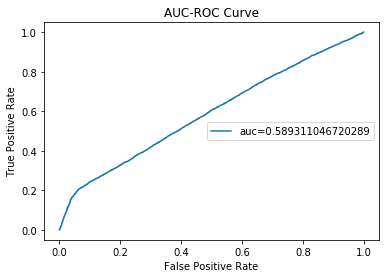

In [19]:
y_pred_proba = logreg.predict_proba(x_test)[::,1]


y_pred_proba

fpr,tpr,thresholds=roc_curve(y_test,y_pred_proba) # the function roc_curve returns three values, the False Positive Rate,True Positive rate
                                                # threshold values it used to calculate the TPR and FPR

auc = roc_auc_score(y_test, y_pred_proba)

plt.plot(fpr,tpr,label="auc="+str(auc))              
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve')

plt.legend(loc=5)
plt.show()

